# Football pass probability model
> A notebook exploring a dataset of football match 'event' data to build a model which predicts the probability of a pass reaching a teammate.

- toc: true 
- badges: false
- comments: true
- categories: [classification]
- image: images/invincibles.png
- author: Aidan Hood

## Introduction
The aim of this project was to build a proof-of-concept model to predict the probability of a football pass reaching a teammate successfully, based on a dataset of football match event data. The dataset used is the Metrica Sports Sample Data, which can be found at: https://github.com/metrica-sports/sample-data. The Metrica Sports repository also included player tracking data that aligns to the event data sets, which has not been used in this model, but I outline how I think this could be used to build on this model at the end of this notebook.

In short, I approached this problem as a binary classification problem, where a pass can be classified as successful, or not. The probability of the pass being successful can then be simply derived as the probability of a data point belonging to either class, which is easy to derive from almost all classification models. This greatly simplifies the ask and allowed me to use familiar classification modelling techniques as opposed to more complex statistical probability models.

I broadly split the problem into the following stages:
1. Data input and cleaning
2. Data exploration
3. Feature selection and engineering
4. Model selection and training
5. Model evaluation
6. Thought on how this model could be built upon

All in all, I created a model with a balanced accuracy score of ~70% and an ROC AUC score of ~0.75. This was pretty good, although far from perfect, and could definitley be improved on if I worked on this project full time.

This notebook includes the full code for the project, but I have made the code snippets collapsable in case you are just interested in the explanations and outputs.

Thanks for reading!

## Libraries

The imported libraries are fairly standard, including various sklearn packages, pandas and matplotlib. The only rogue library I utilised was the imbalanced-learn library (https://github.com/scikit-learn-contrib/imbalanced-learn), which helped with dealing with class imbalance. I also filtered out warnings as they were getting annoying without actually telling me much.

In [373]:
#collapse-hide
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("max_columns", 50)

## Data cleaning
The first step was to read in the dataset and quickly take a look at the dataframe.

In [374]:
#collapse-hide
df = pd.read_csv("./Sample_Game_1/Sample_Game_1_RawEventsData.csv")
df

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


Next, I thought it would be useful to look at what unique values were under the 'Type' column and the 'Subtype' column - i.e. what different types of events were in the dataset. This through up a significant number of subtypes.

In [375]:
#collapse-hide
print('Types: ',df.Type.unique(),'\n')
print('Subtypes: ',df.Subtype.unique())

Types:  ['SET PIECE' 'PASS' 'BALL LOST' 'RECOVERY' 'CHALLENGE' 'BALL OUT' 'SHOT'
 'FAULT RECEIVED' 'CARD'] 

Subtypes:  ['KICK OFF' nan 'INTERCEPTION' 'HEAD-INTERCEPTION' 'AERIAL-LOST'
 'AERIAL-WON' 'HEAD' 'CORNER KICK' 'CROSS' 'HEAD-ON TARGET-GOAL'
 'THROW IN' 'GROUND-LOST' 'GROUND-WON' 'TACKLE-WON' 'THEFT' 'TACKLE-LOST'
 'OFF TARGET-OUT' 'GOAL KICK' 'CROSS-INTERCEPTION'
 'GOAL KICK-INTERCEPTION' 'DEEP BALL' 'ON TARGET-SAVED' 'SAVED'
 'HEAD-FORCED' 'AERIAL-FAULT-LOST' 'AERIAL-FAULT-WON' 'FREE KICK'
 'HEAD-CLEARANCE' 'CLEARANCE' 'GROUND-FAULT-WON' 'GROUND-FAULT-LOST'
 'HEAD-OFF TARGET-OUT' 'DRIBBLE-WON' 'OFFSIDE' 'TACKLE-FAULT-LOST'
 'TACKLE-FAULT-WON' 'GROUND' 'FORCED' 'YELLOW' 'THROUGH BALL-DEEP BALL'
 'HEAD-ON TARGET-SAVED' 'BLOCKED' 'TACKLE-ADVANTAGE-LOST'
 'TACKLE-ADVANTAGE-WON' 'GROUND-ADVANTAGE-LOST' 'END HALF'
 'HEAD-WOODWORK-OUT' 'WOODWORK-GOAL' 'ON TARGET-GOAL' 'WOODWORK'
 'REFEREE HIT' 'OFF TARGET']


To narrow the dataset down to just the passes and attempted passes, I created two new dataframes; one for all datapoints under the 'pass' type, and one for all datapoints under the 'ball lost' type.

I then looked at the subtypes of both the 'pass' dataframe and the 'ball lost' dataframe, which still included many subtypes that were not relevant, specifically in the 'ball lost' dataframe.

In [376]:
#collapse-hide
df_pass = df[df['Type'] =='PASS']
df_lost = df[df['Type'] =='BALL LOST']

print('Pass Subtypes: ',df_pass.Subtype.unique(),'\n')
print('Ball Lost Subtypes: ',df_lost.Subtype.unique())

Pass Subtypes:  [nan 'HEAD' 'CROSS' 'GOAL KICK' 'DEEP BALL' 'THROUGH BALL-DEEP BALL'
 'HEAD-CLEARANCE' 'CLEARANCE'] 

Ball Lost Subtypes:  ['INTERCEPTION' 'HEAD-INTERCEPTION' nan 'THEFT' 'HEAD'
 'CROSS-INTERCEPTION' 'GOAL KICK-INTERCEPTION' 'HEAD-FORCED' 'OFFSIDE'
 'FORCED' 'CLEARANCE' 'END HALF' 'GOAL KICK' 'HEAD-CLEARANCE' 'DEEP BALL'
 'WOODWORK' 'REFEREE HIT']


The 'ball lost' data still needed trimming to remove all the irrelevant subtypes. To do this I wrote some code which only kept the various 'interception' subtypes, as well as the two 'clearance' subtypes, the 'goal kick' subtype and the 'deep ball' subtype.

In [377]:
#collapse-hide
condition = (df_lost.Subtype != '') & (df_lost.Subtype != ' ') & (df_lost.Subtype != 'THEFT') &  (df_lost.Subtype != 'HEAD') & (df_lost.Subtype != 'HEAD-FORCED') & (df_lost.Subtype != 'OFFSIDE') &  (df_lost.Subtype != 'FORCED') & (df_lost.Subtype != 'END HALF') & (df_lost.Subtype != 'WOODWORK') & (df_lost.Subtype != 'REFEREE HIT')

df_lost_trimmed = df_lost[condition]
df_lost_trimmed = df_lost_trimmed.dropna(subset=['Subtype'])

So, now I had what I believed to be all the types of events which constitute either a successful pass, or a failed pass. I have assumed that set pieces do not count as passes, offsides are discounted and clearances do count as passes.

In [378]:
#collapse-hide
print('Pass Subtypes: ',df_pass.Subtype.unique(),'\n')
print('Ball Lost Subtypes: ',df_lost_trimmed.Subtype.unique())

Pass Subtypes:  [nan 'HEAD' 'CROSS' 'GOAL KICK' 'DEEP BALL' 'THROUGH BALL-DEEP BALL'
 'HEAD-CLEARANCE' 'CLEARANCE'] 

Ball Lost Subtypes:  ['INTERCEPTION' 'HEAD-INTERCEPTION' 'CROSS-INTERCEPTION'
 'GOAL KICK-INTERCEPTION' 'CLEARANCE' 'GOAL KICK' 'HEAD-CLEARANCE'
 'DEEP BALL']


With the data trimmed down to just pass related data, I put the two dataframes back together into a master 'pass' dataframe and did some additionally cleaning. This included:
- Renaming the ‘type’ column to 'pass_success', where any 'pass' type was converted to 1 and any 'ball lost' type to 0. This now is the dependent variable.
- Fill any NaN values appropriately. For 'subtype' NaN values, I relabelled these as 'standard' to represent passes/attempted passes without a subtype.
- Standardised the subtypes so that they are independent of if the pass was successful or not. For example, I ensured that datapoints labelled as 'cross-interception' and 'cross' were both just labelled as 'cross' subtypes. This, combined with the above bullet point, allowed me to simplify the data even further to the point of having 6 subtypes of pass/attempted pass: 'STANDARD', 'HEAD', 'CROSS', 'GOAL KICK', 'DEEP BALL', 'CLEARANCE'.
- Changing the 'Team' column to a binary feature of 'home_team' where 1 represents the home team and 0 the away team.
- Changing the 'Period' column values from 1 and 2, to 0 and 1 respectively, and renaming the column to 'first_half' 

After all this, the dataframe is clean, and is just representing successful and failed passes! See below for what it now looks like.

In [379]:
#collapse-hide
pass_data = pd.concat([df_pass, df_lost_trimmed])

pass_data.rename(columns={'Type': 'pass_sucess'}, inplace=True)
pass_data["pass_sucess"].replace({"PASS": 1, "BALL LOST": 0}, inplace=True)

pass_data.dropna(subset = ["End X"], inplace=True)

pass_data["Subtype"].fillna("STANDARD", inplace=True)

pass_data["Subtype"].replace({"INTERCEPTION": "STANDARD"}, inplace=True)
pass_data["Subtype"].replace({"HEAD-INTERCEPTION": "HEAD"}, inplace=True)
pass_data["Subtype"].replace({"THROUGH BALL-DEEP BALL": "DEEP BALL"}, inplace=True)
pass_data["Subtype"].replace({"CROSS-INTERCEPTION": "CROSS"}, inplace=True)
pass_data["Subtype"].replace({"HEAD-CLEARANCE": "CLEARANCE"}, inplace=True)
pass_data["Subtype"].replace({"GOAL KICK-INTERCEPTION": "GOAL KICK"}, inplace=True)

pass_data["Team"].replace({"Away": 0}, inplace=True)
pass_data["Team"].replace({"Home": 1}, inplace=True)
pass_data.rename(columns={'Team': 'home_team'}, inplace=True)

pass_data["Period"].replace({2: 0}, inplace=True)
pass_data.rename(columns={'Period': 'first_half'}, inplace=True)

pass_data

,home_team,pass_sucess,Subtype,first_half,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,0,1,STANDARD,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,0,1,STANDARD,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,0,1,STANDARD,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,0,1,STANDARD,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,0,1,STANDARD,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1,0,STANDARD,0,140619,5624.76,140681,5627.24,Player7,NaN,0.72,0.11,0.42,0.17
1732,0,0,STANDARD,0,142886,5715.44,142938,5717.52,Player27,NaN,0.72,0.08,0.85,0.32
1734,1,0,CLEARANCE,0,142943,5717.72,143008,5720.32,Player2,NaN,0.85,0.32,0.48,0.34
1737,0,0,STANDARD,0,143229,5729.16,143247,5729.88,Player18,NaN,0.68,0.30,0.77,0.23


## Data exploration
Firstly, I wanted to get a feel for the distribution of all the features. The important things to note from this visualisation are:
- The classes are substantially imbalanced, with many more passes being successful than failed. This caused issues with the model and are addressed later in the project.
- The 'start time' and 'end time' features, are carbon copies of the 'start frame' and 'end frame' features, albeit with different scales. As such, one set of these can be removed, which is handled later.
- It is interesting that 'standard' passes are by far the most common.
- There are several features which are categorical. This is handled later.


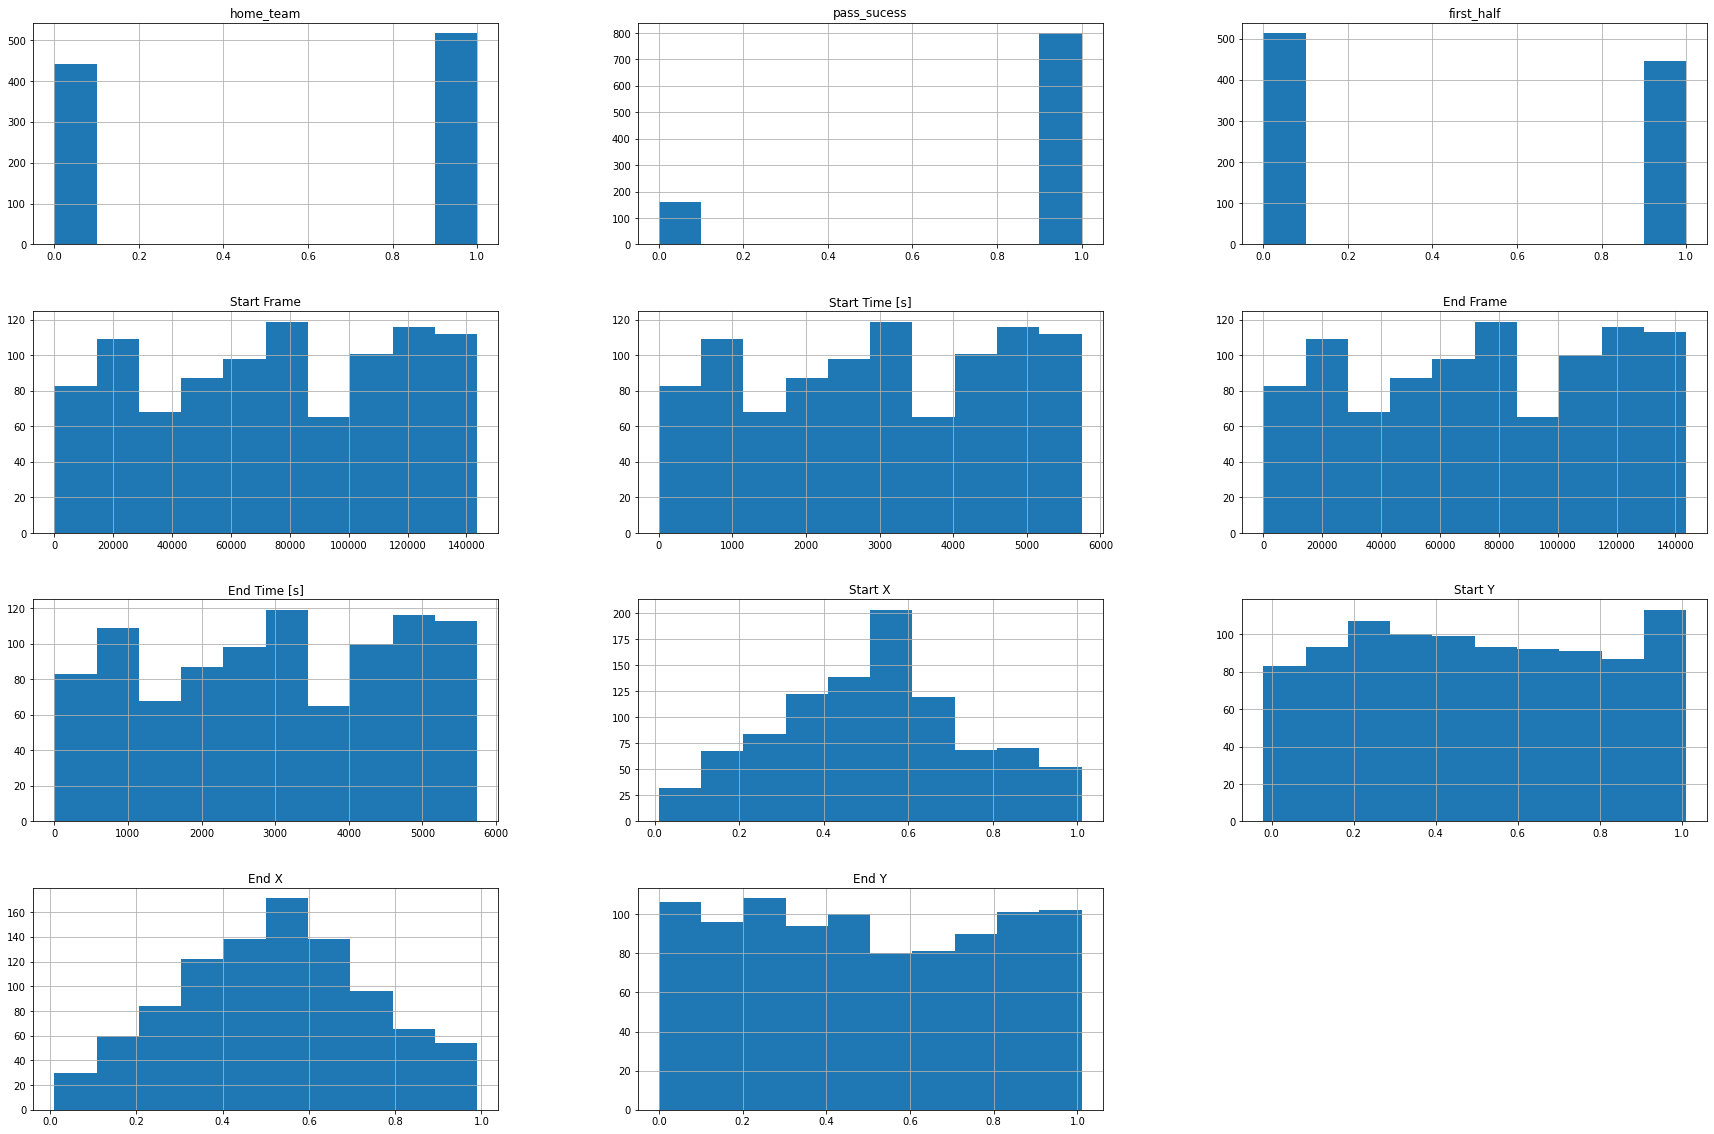

In [380]:
#collapse-hide
pass_data.hist(figsize=(30,20))
plt.show()

<AxesSubplot:>

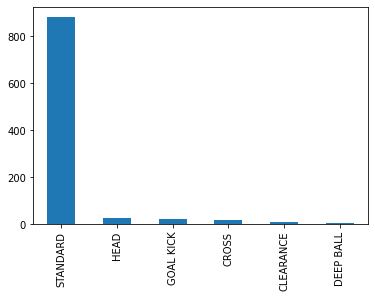

In [381]:
#collapse-hide
pass_data['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

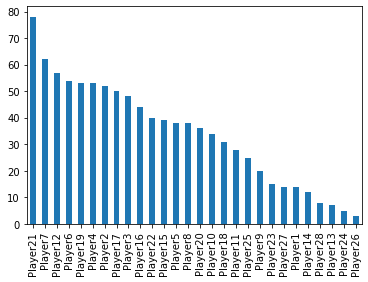

In [382]:
#collapse-hide
pass_data['From'].value_counts().plot(kind='bar')

<AxesSubplot:>

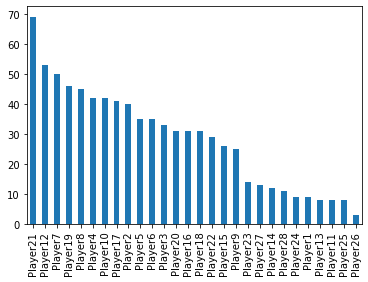

In [383]:
#collapse-hide
pass_data['To'].value_counts().plot(kind='bar')

## Feature selection and engineering
Firstly, I dealt with the duplicated data by taking out the 'start frame' and 'end frame' features, as their information was captured by the time columns. 

I also removed the 'To' column. This was a feature that I had to really think about omitting. On one hand, it holds some valuable information, as there could be a relationship between pass success and which player was being passed to. However, the dataset did not include 'To' data for passes that were incomplete/failed/intercepted. As such, I would not have this data for the failed pass class, and this would cause major issues in the model as the model would essentially know if a pass was successful just from seeing that the 'To' column had a value. As a result, I decided to just omit the feature for integrity and, to some degree, simplicity.

I also questioned the utility of the 'end time' feature. Any information about the game, such as how long the game had been played for, would be captured in the start time feature. The only additional information that the end time feature carries is how long the pass took to reach a teammate or be intercepted. As such, I created a new column called 'pass_length' which was equal to the 'end time' minus the 'start time’ and removed the 'end time' column from the data.

After all this feature selection, the dataframe was close to being in its final state.


In [384]:
#collapse-hide
pass_data.drop(['Start Frame', 'End Frame', 'To'], axis=1, inplace=True)

new_column = pass_data["End Time [s]"] - pass_data["Start Time [s]"]
pass_data["pass_length"] = new_column

pass_data.drop(['End Time [s]'], axis=1, inplace=True)

pass_data

,home_team,pass_sucess,Subtype,first_half,Start Time [s],From,Start X,Start Y,End X,End Y,pass_length
1,0,1,STANDARD,1,0.04,Player19,0.45,0.39,0.55,0.43,0.08
2,0,1,STANDARD,1,0.12,Player21,0.55,0.43,0.58,0.21,0.56
3,0,1,STANDARD,1,1.80,Player15,0.55,0.19,0.45,0.31,0.64
4,0,1,STANDARD,1,3.08,Player19,0.45,0.32,0.49,0.47,0.76
5,0,1,STANDARD,1,7.64,Player21,0.40,0.73,0.32,0.98,1.04
...,...,...,...,...,...,...,...,...,...,...,...
1712,1,0,STANDARD,0,5624.76,Player7,0.72,0.11,0.42,0.17,2.48
1732,0,0,STANDARD,0,5715.44,Player27,0.72,0.08,0.85,0.32,2.08
1734,1,0,CLEARANCE,0,5717.72,Player2,0.85,0.32,0.48,0.34,2.60
1737,0,0,STANDARD,0,5729.16,Player18,0.68,0.30,0.77,0.23,0.72


I then split the dataframe into two; one for the dependent variable 'y' (the class variable; successful pass or failed pass), and a feature dataframe 'x'.

The feature dataframe still had a couple of categorical variables, so I utilised one-hot encoding to convert these to multiple binary features. This was done for the 'Subtype' feature, and the 'From' feature, to give binary features for every subtype of pass and every passing player.

I did not utilise normalization as this reduced the accuracy of my models in the model selection stage. Regardless, with normalization enabled or disabled, the random forest classifier was the highest performing model, and as random forest classifiers do not require normalization, I believe this step is fine to be omitted.

The final form of the feature dataframe can be seen below. The y dataframe is merely a single column of 1's or 0's, so I have not visualised it here.


In [385]:
#collapse-hide
x = pass_data.drop(['pass_sucess'], axis=1)
y = pass_data['pass_sucess']

cat_features_string = ['Subtype','From']
cat_features = [x.Subtype, x.From]

for i in range(len(cat_features_string)):
    x_temp = pd.get_dummies(cat_features[i], prefix=cat_features_string[i])
    x = x.drop(cat_features_string[i],axis=1)
    x = x.join(x_temp)

x

,home_team,first_half,Start Time [s],Start X,Start Y,End X,End Y,pass_length,Subtype_CLEARANCE,Subtype_CROSS,Subtype_DEEP BALL,Subtype_GOAL KICK,Subtype_HEAD,Subtype_STANDARD,From_Player1,From_Player10,From_Player11,From_Player12,From_Player13,From_Player14,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player24,From_Player25,From_Player26,From_Player27,From_Player28,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9
1,0,1,0.04,0.45,0.39,0.55,0.43,0.08,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0.12,0.55,0.43,0.58,0.21,0.56,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1.80,0.55,0.19,0.45,0.31,0.64,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,3.08,0.45,0.32,0.49,0.47,0.76,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,7.64,0.40,0.73,0.32,0.98,1.04,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1,0,5624.76,0.72,0.11,0.42,0.17,2.48,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1732,0,0,5715.44,0.72,0.08,0.85,0.32,2.08,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1734,1,0,5717.72,0.85,0.32,0.48,0.34,2.60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1737,0,0,5729.16,0.68,0.30,0.77,0.23,0.72,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model selection and training
Before selecting a model, I split the data into training and test sets, at an 80/20% split.

Additionally, I had several issues with my models returning a high accuracy, but only because the dataset is imbalanced. The large number of successful passes compared to the low number of failed passes meant that my models were prone to labelling almost all the passes as successful, resulting in a high accuracy. In reality, this wasn't very useful, as the predictions for failed passes were very inaccurate. To solve this issue, I used random under sampling to reduce the number of successful pass datapoints, and SMOTE oversampling to boost the number of failed pass samples (albeit by creating synthetic datapoints). This resulted in an even distribution of successful and failed pass datapoints, which greatly improved the ROC AUC score of my models. The trade-offs of this approach are discussed in the model evaluation section.


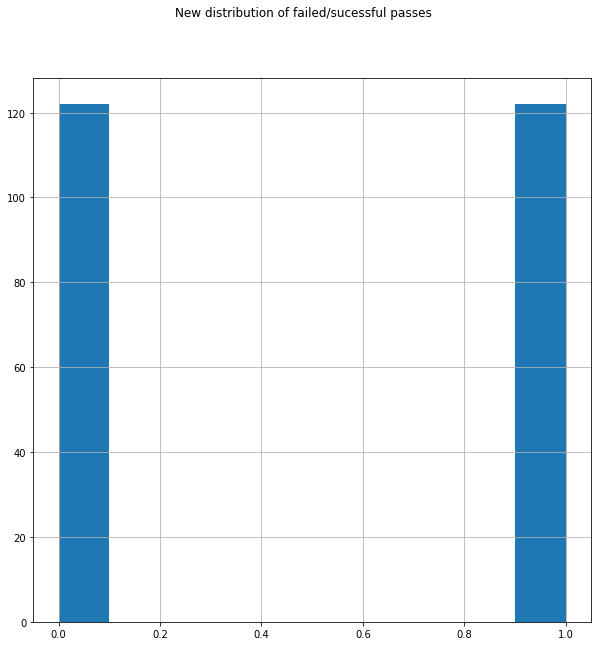

In [386]:
#collapse-hide
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(x_train, y_train)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

y_train.hist(figsize=(10,10))
plt.suptitle("New distribution of failed/sucessful passes")
plt.show()

Next, I defined a list of models which I wanted to test on the data. This is my usual approach, as I think it is quick and easy to test multiple models on a dataset and find the best performing model. I chose a variety of classification models which I am familiar with. I also tested some bagging, stacking, and boosting models after I had finished the project to see if these would improve performance, but they did not, so I have not included these here.

Once I had defined which models I would be testing on the data, I created a set of cross-validation sets via the sklearn KFold validator class. This allowed me to generate preliminary scores for each model via cross-validation, without having to fully test each model.

I chose to evaluate my model at this stage with 3 scores: F1 score, accuracy, and balanced accuracy. Accuracy is always handy to see, but I did not want to rely on it, especially as the dataset was imbalanced to start with. I also included F1 score and a 'balanced' accuracy metric, which together should shed some greater light on the performance of the models. Ultimately I was guided by the balanced accuracy scores for which model was best performing, as this shows the average of recall attained across the two classes, which is a good indicator of model performance for imbalanced datasets. Once I had employed under sampling/oversampling, accuracy may have been OK to use, but I still put the majority of my trust in the balanced accuracy score.

The scores of each model can be seen below. Consistently, the Naive Bayes classifier and the Random Forest classifier came out on top. I chose to go ahead with the Random Forest classifier as it allowed for better predictions of pass probability than the Naive Bayes classifier. Note that the scores are lower than for the completed model due to the small sample sizes used in this preliminary testing.



In [387]:
#collapse-hide
log_regression = linear_model.LogisticRegression()
n_bayes = naive_bayes.GaussianNB()
sgd = linear_model.SGDClassifier()
knn = neighbors.KNeighborsClassifier()
rand_forest = ensemble.RandomForestClassifier(n_jobs=-1)
svc = svm.SVC()

models = [log_regression, n_bayes, sgd, knn, rand_forest, svc]
model_names = ['Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Descent','K-Nearest-Neighbours', 'Random Forest', 'Support Vector Classifier']

print('F1:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='f1')
    print(model_names[i] + ': ' + str(result.mean()) )

print('\nAccuracy:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='accuracy')
    print(model_names[i] + ': ' + str(result.mean()) )

print('\nBalanced Accuracy:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='balanced_accuracy')
    print(model_names[i] + ': ' + str(result.mean()) )

F1:
Logistic Regression: 0.3361118694969627
Naive Bayes: 0.5081979272647476
Stochastic Gradient Descent: 0.3827493261455525
K-Nearest-Neighbours: 0.2783027179419409
Random Forest: 0.40219618114354955
Support Vector Classifier: 0.09316770186335403

Accuracy:
Logistic Regression: 0.40552220888355345
Naive Bayes: 0.6240096038415367
Stochastic Gradient Descent: 0.07346938775510203
K-Nearest-Neighbours: 0.3525810324129651
Random Forest: 0.5858343337334935
Support Vector Classifier: 0.08979591836734693

Balanced Accuracy:
Logistic Regression: 0.40513538748832867
Naive Bayes: 0.62328264639189
Stochastic Gradient Descent: 0.35714285714285715
K-Nearest-Neighbours: 0.3529811924769907
Random Forest: 0.5782246231826063
Support Vector Classifier: 0.08857543017206883


Next, I did some hyperparameter tuning on my chosen model to ensure that I was using the optimal parameters in the model. The code below outputs the optimal parameters to be used.

In [398]:
#collapse-hide
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
            }

grid = GridSearchCV(rand_forest, param_grid = parameters, scoring='balanced_accuracy', verbose=1)
grid.fit(x_train, y_train)
print(grid.best_params_)  

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'criterion': 'entropy', 'max_features': 'sqrt'}


At this point I had found the optimal model, and the optimal parameters for the model. As such, I was ready to build the model with the optimised parameters and train it on the data. Once training was complete, I ran the model on the test dataset, and derived final balanced accuracy and F1 scores. These scores hovered around 0.7 and 0.8 respectively, which is pretty good!

In [409]:
#collapse-hide
rand_forest = ensemble.RandomForestClassifier(criterion = 'entropy', max_features='sqrt', n_jobs=-1)
rand_forest.fit(x_train,y_train)

predictions = rand_forest.predict(x_test)
accuracy = metrics.balanced_accuracy_score(y_test,predictions)
f1 = metrics.f1_score(y_test,predictions)
print('Balanced Accuracy: '+str(accuracy))
print('F1 Score: '+str(f1))


Balanced Accuracy: 0.7435047951176983
F1 Score: 0.8014705882352942


Now that the model is built, we can use it to predict the probability of a pass being successful. The model I chose was a random forest classifier, so the probability is derived from the proportion of sub-trees in the forest that predict the datapoint will be a successful pass. Although not as statistically hardcore as some other probabilistic models, this is a simple and effective approach, and allows me to output the probabilities of various pass datapoints. Below is an example, which shows a datapoint's probabilities being a 22% chance of pass failure, and a 78% chance of pass success.

In [410]:
#collapse-hide
probs = rand_forest.predict_proba(x_test)
print(probs[42])

[0.22 0.78]


## Model evaluation
The balanced accuracy scores and F1 scores gave me an indication of model performance, but I wanted to see a better representation of how well my model was classifying the passes. To do this I plotted a confusion matrix, and a ROC curve.

The confusion matrix shows that the model is mostly predicting the correct classes. Before I employed oversampling and under sampling, this confusion matrix was very skewed, being very accurate at predicting successful passes, but terrible at predicting failed passes.

The ROC curve shows the relationship between the false positive rate and the true positive rate. The area under the curve (AUC) can be used as a metric of how well the model distinguishes between the two classes. Here, the AUC score is quite high, landing between ~ 0.7 and 0.8.


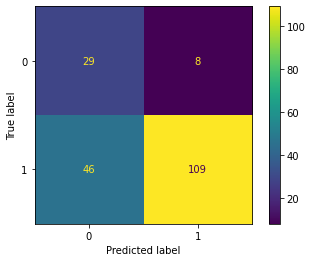

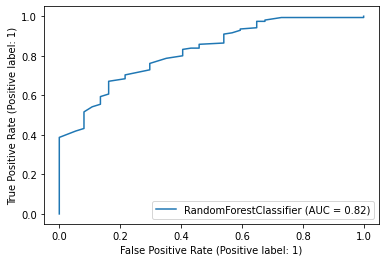

In [417]:
#collapse-hide
c_matrix = metrics.plot_confusion_matrix(rand_forest, x_test,y_test)
metrics.plot_roc_curve(rand_forest, x_test,y_test)
plt.show()

The final piece of evaluation I did was to visualise which features were most significant to the model. Luckily, most classification models have an easy way to view this, and the graph below shows the results.

Pass length was the most influential feature, which makes sense. The passer's coordinates, the receivers coordinates and the time at which the ball was passed were also all major contributors. Home/away team had some impact, as did which half the pass was played in.

As for types of passes, a pass being a standard pass had the highest influence on classification, which makes sense as these are likely to be the simplest pass to pull off.

Which player was the passer had some influence, of varying degrees, but this was generally less important that the other features.


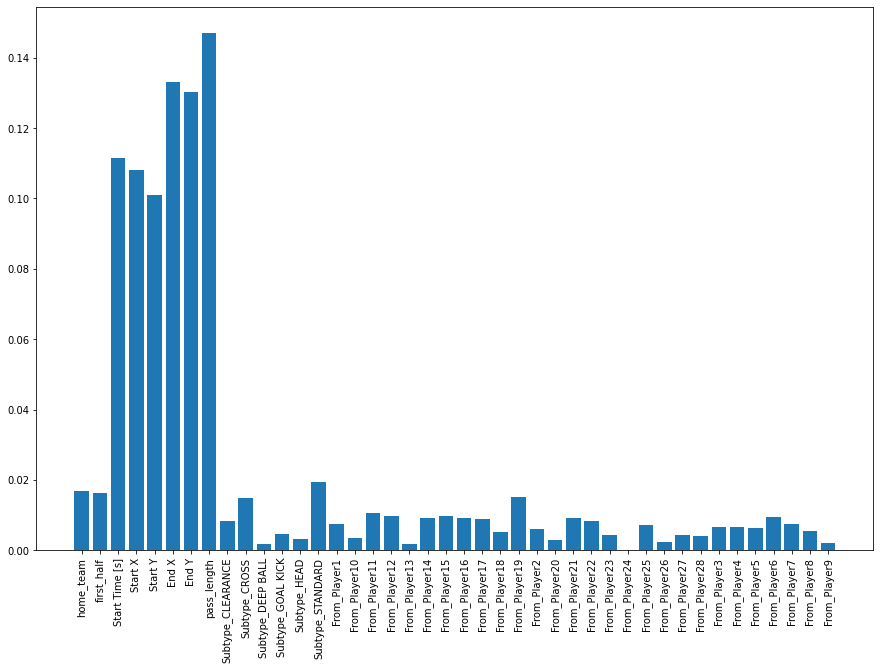

In [418]:
#collapse-hide
feature_importances = rand_forest.feature_importances_
feature_strings = x_train.columns.tolist()
fig = plt.figure(figsize=[15,10])
plt.xticks(rotation=90)
plt.bar(feature_strings, feature_importances)
plt.show()

Finally, I tested all the above code on the second game's data in the Metrica repository, and I got similar results, which proves the model is somewhat robust!

## Further work
Although my model performs well, there were a load of ideas which I thought would benefit the model which I have not had time to implement. These are listed below:

- The dataset also came with tracking data of the players for the game. This could have been used to derive 3 extra features. Firstly, a 'pressure' metric could have been derived based on the number of opposition players near the passer at the time of the pass. This would likely have a good influence on pass success rates. Secondly, a fatigue metric could have been derived from how far a player has run up to the point of a pass. The fatigue of a player would likely affect the probability of a pass being successful. Finally, the distribution of teammates and opposition on the pitch at the time of the pass could have been utilised, as I am sure this would have an influence on pass success.
- The position of players (e.g., left winger) could have had an influence on pass probability, if we had this data. That being said, I already had player data, so this could be redundant. Nonetheless, it would have been interesting to experiment with.
- Rather than using x and y coordinates, splitting the pitch into a grid, and using an 'area of pitch' feature could have been useful. Even if this did not improve performance, the visualisation of this feature could be very useful.
- Using a 'game state' feature(s), which accounts for the score, any yellow/red cards, the importance of the game etc. could have been useful.
- I would have loved to have been able to use more data. If I had historic game data, I could have done a variety of interesting things, such as creating player and team profiles across multiple games, as well as having much more data to train and test on.
- I approached this problem as a binary classification problem, with associated class probabilities. This worked, but I am sure there are more pure statistical methods for approaching this problem. The research and implementation of these methods would be of interest.
- Finally, taking the next step into production of this model is an interesting and complex challenge. The world of ML ops is new to me, but utilising a model on real-world data, monitoring the model's performance, and making iterative improvements is an exciting challenge. To do this properly, I think a constant feed of both new and historic data is necessary and adapting the model to account for multiple games' data is a must.
